# <div align = "center"> Mining Frequent Substructures

## _Group 4 - Final Project_
Harris Mahmood Khawar, Paul Jackson, Drake Kufwafwa, Henry Fox-Jurkowitz  
_COSC-254: Data Mining_  
Professor Matteo Riondato 



NOTES: 
1. This project also contains test datasets created by us, which can be used to ensure the accuracy of the algorithms. The file: ```test-graph-desc.pdf``` contains information about the test datasets. Please find the ```Main``` cell to run the algorithms with specific parameters and see the results.

2. This notebook is divided into two sections: _Implementation_ & _Evaluation_. The first section includes both the algorithms followed by cells to run the algorithms separately. The second section includes different experiments on the both the algorithms.

3. This project is confined to undirected graphs.

# <div align="center"> Section 1: Implementation

## Setup & Helper Methods:

In [71]:
import snap
import glob
import itertools
import time
import matplotlib.pyplot as plt


# return list of graphs in given directory
def get_graph_database(dir_path):
    graph_paths = glob.glob(dir_path)
    graph_database = []
    
    for path in graph_paths:
        graph_database.append(snap.LoadEdgeList(snap.TUNGraph, path, 0, 1))
    
    return graph_database


#returns list of randomly generated undirected graphs
def get_random_graph_database(numEdges, numNodes, numGraphs):
    graph_database=[]

    for i in range(numGraphs):
        graph_database.append(snap.GenRndGnm(snap.TUNGraph, numNodes, numEdges, False))        
    
    return graph_database


# return all graph edges as list
def list_graph(graph):
    graph_list = []
    
    if graph.GetEdges() == 0:
        for N in graph.Nodes():
            graph_list.append(N.GetId())
    else:
        for E in graph.Edges():
            curr_edge = (E.GetSrcNId(), E.GetDstNId())
            graph_list.append(curr_edge)
    
    return graph_list
         

# print graphs and their supports / print dict
def print_dict(D, opt):
    if opt == "graph":
        for graph in D.keys():
            print("Graph: {}, Support: {}".format(list_graph(graph), D[graph]))    
    else:
        for key in D.keys():
            print("Key : {} , Value : {}".format(key, D[key]))

# return true if given graphs are the same
def compare_graphs(G1, G2):
    
    if G1.GetNodes() != G2.GetNodes() or G1.GetEdges() != G2.GetEdges(): 
        return False
    
    for N in G1.Nodes():
        if not G2.IsNode(N.GetId()): return False
    
    for E in G1.Edges():
        if not G2.IsEdge(E.GetSrcNId(), E.GetDstNId()): return False
        
    return True   

## Node-based Join Growth Algorithm:

In [64]:
# Node-based Join Growth

'''
NOTE: (get_all_node_supports) 
This method assumes that there are no label repitions in any of the graphs.
That is, none of the graphs have more than one node with ID x.
'''
# return dict with all nodes in g and their support
def get_all_node_supports(graph_database):
    NS = {}
    
    for graph in graph_database:
        for N in graph.Nodes():
            curr_node = N.GetId()
            if curr_node in NS:
                NS[curr_node] += 1
            else:
                NS[curr_node] = 1
    
    return NS


# return dict with frequent singleton graphs and their supports
def get_frequent_singleton_graphs(NS, minsup):
    F1 = {}
    
    for N in NS:
        if NS[N] >= minsup:
            subgraph = snap.TUNGraph.New() # create new graph
            subgraph.AddNode(N) # add frequent node
            F1[subgraph] = NS[N] # graph support = node support
    
    return F1


# return candidate by joining singletons
def get_singleton_joins(g):
    ES = get_all_edge_supports(g)
    candidates = []
    
    for E in ES.keys():
        sG = snap.TUNGraph.New()
        sG.AddNode(E[0])
        sG.AddNode(E[1])
        sG.AddEdge(E[0], E[1])
        candidates.append(sG)
        
    return candidates

'''
NOTE: (subgraph_match)
The book recommends Ullman's Algorithm for this,
which is recursive. I am not a fan recursion so I made the following,
which might not be as efficient but does the job.
'''
# return node and edge if they are the only non-matching ones
def subgraph_match(Gq, G):
    nmE_f = False # non-matching node found
    nmN_f = False # non-matching edge found
    nmN = None # non_matching node
    nmE = None # non-matching edge

    res = False

    for E in Gq.Edges():
        if not G.IsEdge(E.GetSrcNId(), E.GetDstNId()):
            if nmE_f:
                nmE_f = False
                break
            else:
                nmE = (E.GetSrcNId(), E.GetDstNId())
                nmE_f = True
    
    if nmE_f:
        for N in Gq.Nodes():
            if not G.IsNode(N.GetId()):
                if nmN_f:
                    nmN_f = False
                    break
                else:
                    nmN = N.GetId()
                    if nmN in nmE:
                        nmN_f = True
                    else:
                        break
                        
    if nmN_f and nmE_f:
        res = True
    
    return res, nmE, nmN


# return candidates by performing node-based joins    
def join_subgraphs(subgraph1, subgraph2, nmE, nmN):
    
    # create new candidate subgraphs
    c1 = snap.TUNGraph.New()
    c2 = snap.TUNGraph.New()
    
    # hold non-matching node in subgraph2
    for N in subgraph2.Nodes():
        if not subgraph1.IsNode(N.GetId()):
            nmN_s2 = N.GetId()
    
    c1 = snap.ConvertGraph(type(subgraph2), subgraph2) # copy subgraph1
    c1.AddNode(nmN) # add non-matching node from subgraph1
    c1.AddEdge(nmE[0], nmE[1]) # add non-matching edge
    
    c2 = snap.ConvertGraph(type(c1), c1) # copy candidate 1
    c2.AddEdge(nmN, nmN_s2) # add edge between non-matching nodes of subgraph1 and subgraph2
    
    return c1, c2


# return true if all k-1 subgraphs of candidate are in Fk
def prune_candidate(c, Fk, k):
    all_edges = []
    
    for E in c.Edges():
        all_edges.append((E.GetSrcNId(), E.GetDstNId()))
    
    # generate all edges subsets
    kMinus1_subsets = list(itertools.combinations(all_edges, k-2))
    
    for subset in kMinus1_subsets:
        sG = snap.TUNGraph.New()
        exists = False
        
        for tup in subset:
            for N in tup:
                if not sG.IsNode(N): sG.AddNode(N)
            sG.AddEdge(tup[0], tup[1])
        
        if sG.GetNodes() < k: 
            for graph in Fk:
                if compare_graphs(graph, sG):
                    exists = True
                    break

            if not exists:
                return False
        
    return True 
    
    
'''
NOTE: (generate_candidates)
This method is incomplete i.e. no optimization/pruning of candidates
'''
# return candidates list by joining graphs in Fk
def generate_candidates(Fk, k, g):
    candidates = []
    
    if k == 2:
        candidates = get_singleton_joins(g)
        
    else:
        for i in range(0, len(Fk)):
            sG1 = Fk[i]

            for j in range(i+1, len(Fk)):
                sG2 = Fk[j]
                
                # join if they each have only one uncommon node
                match, nmE, nmN = subgraph_match(sG1, sG2)
                if match:
                    c1, c2 = join_subgraphs(sG1, sG2, nmE, nmN)
                    for _c in c1, c2:
                        if prune_candidate(_c, Fk, k):
                            candidates.append(_c)
    
    return candidates
        
    
# generate frequent k+1 sized graphs dict by counting C in g
def generate_Fkplus1(C, g, minsup):
    Fkplus1 = {}
    candidate_is_subgraph = True
    support = 0
    
    for candidate in C:
        for graph in g:

            # check if graph contains all candidate's nodes
            for N in candidate.Nodes():
                if not graph.IsNode(N.GetId()):
                    candidate_is_subgraph = False
                    break

            # check if graph contains all candidate's edges    
            if candidate_is_subgraph:        
                for E in candidate.Edges():
                    if not graph.IsEdge(E.GetSrcNId(), E.GetDstNId()):
                        candidate_is_subgraph = False
                        break

            # increment support            
            if candidate_is_subgraph:
                support += 1

            # reset for next graph
            candidate_is_subgraph = True

        if support >= minsup:
            Fkplus1[candidate] = support

        support = 0 # reset support for next candidate
    
    return Fkplus1


'''
NOTE: (update_FsG)
This method is not optimized because it is not necessary.
But it is used because if there cycles in the graphs,
duplicate entries are appended to FsG
'''
# return FsG after appending subgraphs not in FsG from Fk
def update_FsG(Fk, FsG):
    exists = False
    
    # compare each graph in Fk with each graph in FsG
    for g in Fk.keys(): 
        
        for G in FsG.keys():
            
            if compare_graphs(g, G):
                exists = True
                
        if not exists:
            FsG[g] = Fk[g]
            
        exists = False
        
    return FsG


# return dict with frequent subgraphs and support
def node_based_join_growth(g, minsup):

    # NS = { [(NodeId) : Support] }
    NS = get_all_node_supports(g)
    
    # F1 = { All frequent singleton graphs }
    Fk = get_frequent_singleton_graphs(NS, minsup) # frequent k subgraphs
    k = 1
    
    FsG = {} # all frequent subgraphs
    C = [] # candidates from Fk
    
    # Apriori Algorithm:
    while(True):
        C = generate_candidates(list(Fk.keys()), k+1, g)
        Fk = generate_Fkplus1(C, g, minsup)
        
        # end if no more frequent subgraphs
        if not Fk: 
            break
        
        FsG = update_FsG(Fk, FsG) # append all frequent subgraphs
        
        k = k + 1
    
    return FsG

## Edge-based Join Growth Algorithm:

In [65]:
# Edge-based Join Growth

'''
NOTE: (get_all_edge_supports)
This method takes duplication into account.
That is, the edges NodeX-NodeY and NodeY-NodeX are considered the same.
''' 
# return dict will all edges in graph database and their supports
def get_all_edge_supports(graph_database):
        ES = {}    
        
        for graph in graph_database:
            for E in graph.Edges():
                curr_edge = (E.GetSrcNId(), E.GetDstNId())
                curr_edge_flip = (E.GetDstNId(), E.GetSrcNId())
                if curr_edge in ES:
                    ES[curr_edge] += 1
                elif curr_edge_flip in ES:
                    ES[curr_edge_flip] += 1
                else:    
                    ES[curr_edge] = 1
        
        return ES


# return all edges that have at least minsup support   
def get_frequent_singleton_graphs_EB(ES, minsup):
    F1 = {}
    
    for E in ES:
        if ES[E] >= minsup:
            subgraph = snap.TUNGraph.New()
            subgraph.AddNode(E[0])
            subgraph.AddNode(E[1])
            subgraph.AddEdge(E[0], E[1])
            F1[subgraph] = ES[E]

    return F1


'''
NOTE: (subgraph_match_EB)
The book recommends Ullman's Algorithm for this,
which is recursive. I am not a fan recursion so I made the following,
which might not be as efficient but does the job.
'''
# return node and edge if they are the only non-matching ones
def subgraph_match_EB(sG1, sG2): 
    nmE_f = False # non-matching node found
    nmE = None # non-matching edge
    
    for E in sG1.Edges():
        if not sG2.IsEdge(E.GetSrcNId(), E.GetDstNId()):
            if nmE_f:
                nmE_f = False
                break
            else:
                nmE = (E.GetSrcNId(), E.GetDstNId())
                nmE_f = True
    
    if nmE_f:
        if sG2.IsNode(nmE[0]) and sG2.IsNode(nmE[1]):
            return True, nmE, None
        elif sG2.IsNode(nmE[0]):
            return True, nmE, nmE[1]
        elif sG2.IsNode(nmE[1]):
            return True, nmE, nmE[0]
    
    return False, None, None
    

# return candidates by performing node-based joins        
def join_subgraphs_EB(subgraph1, subgraph2, nmE, nmN):
    
    c = snap.ConvertGraph(type(subgraph2), subgraph2)

    if nmN is not None:
        c.AddNode(nmN)

    c.AddEdge(nmE[0], nmE[1])
    
    return c


# return true if all k-1 subgraphs of candidate are in Fk
def prune_candidate_EB(c, Fk, k):
    all_edges = []
    
    for E in c.Edges():
        all_edges.append((E.GetSrcNId(), E.GetDstNId()))
    
    # generate all edges subsets
    kMinus1_subsets = list(itertools.combinations(all_edges, len(all_edges)-1))

    for subset in kMinus1_subsets:
        sG = snap.TUNGraph.New()
        exists = False
        
        for tup in subset:
            for N in tup:
                if not sG.IsNode(N): sG.AddNode(N)
            sG.AddEdge(tup[0], tup[1])
        
        if sG.GetNodes() <= len(all_edges):
            for graph in Fk:
                if compare_graphs(graph, sG):
                    exists = True
                    break

            if not exists:
                return False
        
    return True 
       
    
# return candidates list by joining graphs in Fk
def generate_candidates_EB(Fk, k):
    candidates = []
    
    for i in range(0, len(Fk)):
        sG1 = Fk[i]
        
        for j in range(i+1, len(Fk)):
            sG2 = Fk[j]
            match, nmE, nmN = subgraph_match_EB(sG1, sG2)
            if match:
                c = join_subgraphs_EB(sG1, sG2, nmE, nmN)
                if prune_candidate_EB(c, Fk, k):
                    candidates.append(c)
                
    return candidates


# generate frequent k+1 sized graphs dict by counting C in g
def generate_Fkplus1_EB(C, g, minsup): 
    Fkplus1 = {}
    candidate_is_subgraph = True
    support = 0
    
    for candidate in C:
        for graph in g:

            # check if graph contains all candidate's nodes
            for N in candidate.Nodes():
                if not graph.IsNode(N.GetId()):
                    candidate_is_subgraph = False
                    break

            # check if graph contains all candidate's edges    
            if candidate_is_subgraph:        
                for E in candidate.Edges():
                    if not graph.IsEdge(E.GetSrcNId(), E.GetDstNId()):
                        candidate_is_subgraph = False
                        break

            # increment support            
            if candidate_is_subgraph:
                support += 1

            # reset for next graph
            candidate_is_subgraph = True

        if support >= minsup:
            Fkplus1[candidate] = support

        support = 0 # reset support for next candidate
    
    return Fkplus1


'''
NOTE: (update_FsG)
This method is not optimized because it is not necessary.
But it is used because if there cycles in the graphs,
duplicate entries are appended to FsG
'''
# return FsG after appending subgraphs not in FsG from Fk
def update_FsG_EB(Fk, FsG):
    exists = False

    for g in Fk.keys(): 
        for G in FsG.keys():
            
            if compare_graphs(g, G):
                exists = True
                
        if not exists:
            FsG[g] = Fk[g]
            
        exists = False
        
    return FsG


# return dict with frequent subgraphs and support
def edge_based_join_growth(g, minsup):
    
    # ES = { [ [(SrcNodeId), (DstNodeId) : Support] }
    ES = get_all_edge_supports(g)

    # F1 = { All frequent singleton graphs }
    Fk = get_frequent_singleton_graphs_EB(ES, minsup)
    k = 1
    
    FsG = Fk # all frequent subgraphs
    C = [] # candidates from Fk
    
    # Apriori Algotithm
    while(True):
        C = generate_candidates_EB(list(Fk.keys()), k+1)
        Fk = generate_Fkplus1_EB(C, g, minsup)
        
        # end if no more frequent subgraphs
        if not Fk:
            break
        FsG = update_FsG_EB(Fk, FsG) # append all frequent subgraphs
        
        k = k + 1
        
    return FsG

## Main:

The following cell is used to set the following parameters:  
<br>
```input_type```: 1 - to use test-graphs or 2 - to use random graphs  
```input_graphs_path```: Path to directory with input graphs (txt files)  
```numNodes```: Number of Nodes in each graph for generating random graphs  
```numEdges```: Number of Edges in each graph for generating random graphs  
```numGraphs```: Total number of graphs in graph database  
```minsup```: Minimum support  

NOTE: There are two sets of test graphs provided in the datasets directory. Their paths are as follows:  
```"./datasets/test-graphs/*.txt"``` : Nodes: [16, 21, 17, 17], Edges: [22, 32, 23, 25]  
```"./datasets/test-graphs2/*.txt"```: Nodes: [6, 6, 6], Edges: [5, 5, 5]  

In [107]:
# configure inputs and set minimum support
input_type = 1
input_graphs_path = "./datasets/test-graphs/*.txt"
numNodes = 1000
numEdges = 5000
numGraphs = 4

minsup = 3

# g = [G1, G2, G3 ... Gn] 
if input_type == 1:
    g = get_graph_database(input_graphs_path)
elif input_type == 2:
    g = get_random_graph_database(numNodes, numEdges, numGraphs)

### Run Node-Based Join Growth Algorithm:
The following cell uses node-based join growth to mine frequent subgraphs and displays the final result.

In [108]:
# FsG = Frequent subgraphs (with Node-based Join Growth)
FsG = node_based_join_growth(g, minsup)

# Print Results
print_dict(FsG, "graph")
print("Total: ", len(FsG))

Graph: [(1, 5)], Support: 4
Graph: [(1, 12)], Support: 4
Graph: [(5, 6)], Support: 4
Graph: [(19, 20)], Support: 4
Graph: [(3, 8)], Support: 4
Graph: [(3, 9)], Support: 4
Graph: [(3, 11)], Support: 4
Graph: [(8, 9)], Support: 4
Graph: [(4, 6)], Support: 4
Graph: [(4, 12)], Support: 4
Graph: [(13, 18)], Support: 4
Graph: [(13, 19)], Support: 4
Graph: [(18, 20)], Support: 4
Graph: [(1, 5), (1, 12)], Support: 4
Graph: [(5, 6), (1, 5)], Support: 4
Graph: [(4, 12), (1, 12)], Support: 4
Graph: [(4, 6), (5, 6)], Support: 4
Graph: [(13, 19), (19, 20)], Support: 4
Graph: [(18, 20), (19, 20)], Support: 4
Graph: [(3, 8), (3, 9)], Support: 4
Graph: [(3, 8), (3, 9), (8, 9)], Support: 4
Graph: [(3, 8), (3, 11)], Support: 4
Graph: [(8, 9), (3, 8)], Support: 4
Graph: [(3, 9), (3, 11)], Support: 4
Graph: [(8, 9), (3, 9)], Support: 4
Graph: [(4, 6), (4, 12)], Support: 4
Graph: [(13, 18), (13, 19)], Support: 4
Graph: [(18, 20), (13, 18)], Support: 4
Graph: [(5, 6), (1, 5), (1, 12)], Support: 4
Graph: [(4

### Run Edge Based Join Growth Algorithm
The following cell uses edge-based join growth to mine frequent subgraphs and displays the final result.

In [109]:
# FsG_EB = Frequent subgraphs (with Edge-based Join Growth)
FsG_EB = edge_based_join_growth(g, minsup)

# Print Results
print_dict(FsG_EB, "graph")
print("Total: ", len(FsG_EB))

Graph: [(1, 5)], Support: 4
Graph: [(1, 12)], Support: 4
Graph: [(5, 6)], Support: 4
Graph: [(19, 20)], Support: 4
Graph: [(3, 8)], Support: 4
Graph: [(3, 9)], Support: 4
Graph: [(3, 11)], Support: 4
Graph: [(8, 9)], Support: 4
Graph: [(4, 6)], Support: 4
Graph: [(4, 12)], Support: 4
Graph: [(13, 18)], Support: 4
Graph: [(13, 19)], Support: 4
Graph: [(18, 20)], Support: 4
Graph: [(1, 5), (1, 12)], Support: 4
Graph: [(5, 6), (1, 5)], Support: 4
Graph: [(4, 12), (1, 12)], Support: 4
Graph: [(4, 6), (5, 6)], Support: 4
Graph: [(13, 19), (19, 20)], Support: 4
Graph: [(18, 20), (19, 20)], Support: 4
Graph: [(3, 8), (3, 9)], Support: 4
Graph: [(3, 8), (3, 11)], Support: 4
Graph: [(8, 9), (3, 8)], Support: 4
Graph: [(3, 9), (3, 11)], Support: 4
Graph: [(8, 9), (3, 9)], Support: 4
Graph: [(4, 6), (4, 12)], Support: 4
Graph: [(13, 18), (13, 19)], Support: 4
Graph: [(18, 20), (13, 18)], Support: 4
Graph: [(5, 6), (1, 5), (1, 12)], Support: 4
Graph: [(4, 12), (1, 5), (1, 12)], Support: 4
Graph: [

# <div align="center"> Section 2: Evaluation

### Experimental Setup:

For the following experiments,  
```node_amnts```: Number of Nodes in each input Graph  
```edge_amnts```: Number of Edges in each input Graph  
```numGraphs```: Number of Input Graphs  

In [101]:
def get_runtime(numNodes, numEdges, numGraphs, minsup):
    g = get_random_graph_database(numNodes, numEdges, numGraphs)
    
    t0 = time.time()
    FsG = node_based_join_growth(g, minsup)
    t1 = time.time()
    nb_rt = round(t1-t0, 3)
    
    t0 = time.time()
    FsG_EB = edge_based_join_growth(g, minsup) 
    t1 = time.time()
    eb_rt = round(t1-t0, 3)
    
    return nb_rt, eb_rt

### Experiment 1:

In the following experiment, we evaluate the algorithms by calculating their runtimes on the graph databases as the number of nodes and number of edges in each graph increase.

This experiment has a fixed number of graphs and minimum support.
The node numbers increase by a factor of 10 and then 2.
The edge numbers are always 5 times the number of nodes.

In [ ]:
# configurations
node_amnts = [100, 1000, 10000, 20000, 50000, 100000]
edge_amnts = [500, 5000, 50000, 100000, 250000, 500000]
numGraphs = 10
minsup = 2

# node-based/edge-based algorithm runtimes for different configurations
nb_rts = []
eb_rts = []

for i in range(6):
    rts = get_runtime(node_amnts[i], edge_amnts[i], numGraphs, minsup)
    nb_rts.append(rts[0])
    eb_rts.append(rts[1])

### Exp.1 Results:

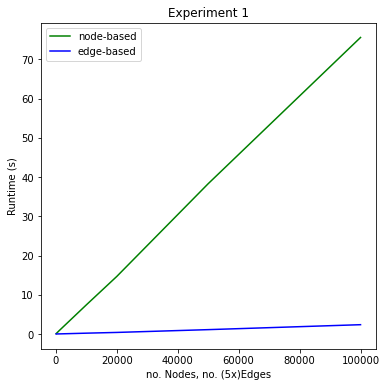

In [100]:
plt.figure(figsize = (6, 6))
plt.plot(node_amnts, nb_rts, 'C1', label='node-based', color="green")
plt.plot(node_amnts, eb_rts, 'C2', label='edge-based', color="blue")
plt.title("Experiment 1")
plt.ylabel("Runtime (s)")
plt.xlabel("no. Nodes, no. (5x)Edges")
plt.legend()
plt.show()

As it can be seen in the above graph, the edge-based join growth method is substantially more efficient than node-based. It can also be seen that both algorithms are robust as their runtimes increase linearly with the number of nodes and edges.

### Experiment 2:

In the following experiment, we evaluate the algorithms by calculating their runtimes as the number of edges in each input graph increase. The number of nodes stays constant as well as the number of graphs.

In [125]:
# configurations
node_amnts = [10000]
edge_amnts = [30000, 50000, 100000, 150000]
numGraphs = 10
minsup = 3

# node-based/edge-based algorithm runtimes for different configurations
nb_rts = []
eb_rts = []

for i in range(4):
    rts = get_runtime(node_amnts[0], edge_amnts[i], numGraphs, minsup)
    nb_rts.append(rts[0])
    eb_rts.append(rts[1])

### Exp.2 Results:

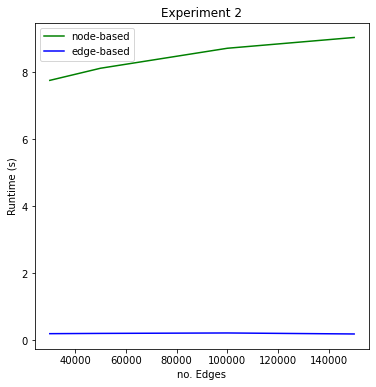

In [126]:
plt.figure(figsize = (6, 6))
plt.plot(edge_amnts, nb_rts, 'C1', label='node-based', color="green")
plt.plot(edge_amnts, eb_rts, 'C2', label='edge-based', color="blue")
plt.title("Experiment 2")
plt.ylabel("Runtime (s)")
plt.xlabel("no. Edges")
plt.legend()
plt.show()

As it can be seen in the graph above, the edge-based implementation still performs much better. Additionally, its runtime stays almost consistent as the number of edges increase. On the other hand, node-based algorithm shows a slight variation however this is a very minor difference which can be ignored.

### Experiment 3:

In the following experiment we evaluate the algorithms by calculating their runtime as the number of nodes increase. The number of edges as well as the number of graphs stay constant.

In [122]:
# configurations
node_amnts = [1000, 10000, 20000, 50000]
edge_amnts = [50000]
numGraphs = 10
minsup = 3

# node-based/edge-based algorithm runtimes for different configurations
nb_rts = []
eb_rts = []

for i in range(4):
    rts = get_runtime(node_amnts[i], edge_amnts[0], numGraphs, minsup)
    nb_rts.append(rts[0])
    eb_rts.append(rts[1])

### Exp.3 Results:

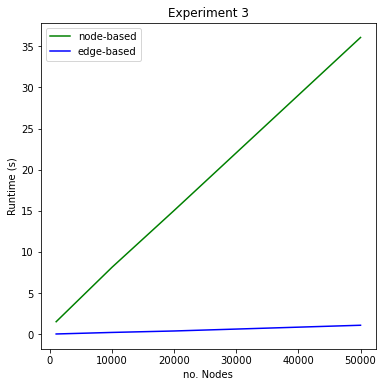

In [123]:
plt.figure(figsize = (6, 6))
plt.plot(node_amnts, nb_rts, 'C1', label='node-based', color="green")
plt.plot(node_amnts, eb_rts, 'C2', label='edge-based', color="blue")
plt.title("Experiment 3")
plt.ylabel("Runtime (s)")
plt.xlabel("no. Nodes")
plt.legend()
plt.show()

### Conclusion:

All the results discussed above conclude that the edge-based join growth implementation is better than the node-based one. This result is as expected due to a couple of reasons. Firstly, the drawback in the node-based implemenation in this project requires to k+1 sized candidates to be generated from each pair of k sized subgraphs. This is because, in the node-based implementation, when there are loops in the graphs, all proper candidates cannot be generated simply by adding another node - an edge needs to be added without adding another node to complete the loop. This cause node-based implementation to generate 2x more candidates and therefore, it requires 2x more pruning, which adds to the runtime.

Secondly, since the edge-based algorithm begins by counting the support on single edges instead of single nodes, it is already one step ahead of node-based implementation. Additionally, in the case of node-based implementation, k refers to the number of nodes in each candidate so when k=1, it counts the support of all nodes, which takes longer than counting edges since no. of nodes is always greater than no. edges in undirected graphs.